In [1]:
import sys, os
pytorchbridge_path = os.path.abspath('../../pyTorchBridge')
if pytorchbridge_path not in sys.path:
    sys.path.append(pytorchbridge_path)

In [2]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import datetime
from os import path, environ
import pickle

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pytorchbridge import TorchEstimator

from utils.stats import temporal_correlations
from plotting import model_surface, plot_surface
from controller import GridSearchController, \
                       BinaryApproachController, \
                       QuasiNewtonController
# source file, see docs/5-dataset.md for info on field names
chiller_file = path.join(environ['DATADIR'],
                         'EngineeringScienceBuilding',
                         'Chillers.csv')
plot_path = path.join('..', 'docs', 'img')

In [3]:
# Data selection 'all' or 'chiller_on' or 'fan_on'
MODE = 'chiller_on'
# Read pre-processed data:
# Pytorch uses float32 as default type for weights etc,
# so input data points are also read in the same type.
df = pd.read_csv(chiller_file, index_col='Time',
                 parse_dates=['Time'], dtype=np.float32)
df.dropna(inplace=True)
if MODE == 'chiller_on':
    df = df[df['PowChi'] != 0.]
if MODE == 'fan_on':
    df = df[(df['PerFreqFanA'] != 0.) | df['PerFreqFanB'] != 0.]
print(len(df), 'Records')

60747 Records


In [4]:
# Time at which to draw sample plots
# time = datetime.time(4,0,0)
time = datetime.date(2018,6,2)

if isinstance(time, datetime.time):
    select = df.index.time == time
    tseries = df.index.date[select]
elif isinstance(time, datetime.date):
    select = df.index.date == time
    tseries = df.index.time[select]

# 1. Post-chiller temp model

In [ ]:
# Data
feature_cols = ('TempCondIn',                 'TempEvapIn',
                'TempEvapOut', 'TempAmbient', 'TempWetBulb',
                'FlowEvap', 'PowConP')
target_cols = ('TempCondOut',)
# Normalizing data to have 0 mean and 1 variance
XChi, YChi = df.loc[:, feature_cols], df.loc[:,target_cols]
ScalerXChi, ScalerYChi = StandardScaler().fit(XChi), StandardScaler().fit(YChi)
XChi, YChi = ScalerXChi.transform(XChi), np.squeeze(ScalerYChi.transform(YChi))
XChitrain, XChitest, YChitrain, YChitest = train_test_split(XChi, YChi, test_size=0.1)

norm_chi_var = lambda i, v: ScalerXChi.mean_[i] + np.sqrt(ScalerXChi.var_[i]) * v
norm_chi = lambda v: ScalerYChi.inverse_transform(v)
std_chi_var = lambda i, v: (v - ScalerXChi.mean_[i]) / np.sqrt(ScalerXChi.var_[i])

CHILLER_MODELS = {}

In [ ]:
# Searching parameter grid for best hyperparameters
param_grid = {
    'hidden_layer_sizes': [(4,4), (8,8), (16,16), (8,8,8), (16,16,16)],
    'learning_rate_init': [1e-2, 1e-3, 1e-4],
    'activation': ['relu', 'tanh', 'logistic']
}

grid_search = GridSearchCV(MLPRegressor(), param_grid, n_jobs=4, verbose=1,
                           cv=KFold(3, shuffle=True))
grid_search.fit(XChitrain, YChitrain)

est = grid_search.best_estimator_
print('Test score:', est.score(XChitest, YChitest))

CHILLER_MODELS['SingleMLP'] = est
pickle.dump(est, open('./bin/chiller_{}.pickle'.format(MODE), 'wb'))

grid_res = pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score')
grid_res.head()

In [ ]:
# Load model from file instead of training
est = pickle.load(open('./bin/chiller_{}.pickle'.format(MODE), 'rb'))
CHILLER_MODELS['SingleMLP'] = est

In [ ]:
# Plot model predictions when varying 2 fields at a single time instant
dt = datetime.datetime(2018, 6, 2, 15, 0, 0)
select = df.index == dt
singleX, singleY = XChi[select], YChi[select]
var, var_idx = ('TempCondIn', 'PowConP'), (0, 6)
vary_range = ((std_chi_var(var_idx[0], 293), 1.),
              (std_chi_var(var_idx[1], 0), 1.5))

x, y, z = model_surface(CHILLER_MODELS['SingleMLP'], singleX, var_idx,
                        vary_range, (10, 10))
ax = plot_surface(norm_chi_var(var_idx[0], x),
                  norm_chi_var(var_idx[1], y),
                  norm_chi(z),
                  alpha=0.75, cmap=plt.get_cmap('coolwarm'))
ax.set_xlabel(var[0], labelpad=20)
ax.set_ylabel(var[1])
ax.set_zlabel('Temperature / K')
plt.title('Temperature Extrapolation ' + dt.isoformat());

# 2. Energy Model

In [ ]:
# Data
feature_cols = ('TempCondIn', 'TempCondOut', 'TempEvapIn',
                'TempEvapOut', 'TempAmbient', 'TempWetBulb',
                'FlowEvap', 'PowConP')
target_cols = ('PowChi',)
# Normalizing data to have 0 mean and 1 variance
XEnergy, YEnergy = df.loc[:, feature_cols], df.loc[:,target_cols]
ScalerXEnergy, ScalerYEnergy = StandardScaler().fit(XEnergy), StandardScaler().fit(YEnergy)
XEnergy, YEnergy = ScalerXEnergy.transform(XEnergy), np.squeeze(ScalerYEnergy.transform(YEnergy))
XEnergytrain, XEnergytest, YEnergytrain, YEnergytest = train_test_split(XEnergy, YEnergy, test_size=0.1)

norm_energy_var = lambda i, v: ScalerXEnergy.mean_[i] + np.sqrt(ScalerXEnergy.var_[i]) * v
norm_energy = lambda v: ScalerYEnergy.inverse_transform(v)
std_energy_var = lambda i, v: (v - ScalerXEnergy.mean_[i]) / np.sqrt(ScalerXEnergy.var_[i])

ENERGY_MODELS = {}

In [ ]:
# Searching parameter grid for best hyperparameters
param_grid = {
    'hidden_layer_sizes': [(4,4), (8,8), (16,16), (8,8,8), (16,16,16)],
    'learning_rate_init': [1e-2, 1e-3, 1e-4],
    'activation': ['relu', 'tanh', 'logistic']
}

grid_search = GridSearchCV(MLPRegressor(), param_grid, n_jobs=4,
                           verbose=1, cv=KFold(3, shuffle=True))
grid_search.fit(XEnergytrain, YEnergytrain)

est = grid_search.best_estimator_
print('Test score:', est.score(XEnergytest, YEnergytest))

ENERGY_MODELS['SingleMLP'] = est
pickle.dump(est, open('./bin/energy_{}.pickle'.format(MODE), 'wb'))

grid_res = pd.DataFrame(grid_search.cv_results_)\
             .sort_values('rank_test_score')
grid_res.head()

In [ ]:
# Load model from file instead of training
est = pickle.load(open('./bin/energy_{}.pickle'.format(MODE), 'rb'))
ENERGY_MODELS['SingleMLP'] = est

In [ ]:
# Plot historic predictions
Xfiltered = XEnergy[select]
Yfiltered = YEnergy[select]

plt.scatter(np.arange(len(tseries)),
            ScalerYEnergy.inverse_transform(Yfiltered),
            c='r', label='Historic')
plt.scatter(np.arange(len(tseries)),
            ScalerYEnergy.inverse_transform(est.predict(Xfiltered)),
            c='g', label='Predicted')
plt.title('Power Model ' + time.isoformat())
plt.ylabel('Power / W')
plt.xlabel('Date/Time')
plt.legend();
ticks, labels = plt.xticks()
ticks = np.asarray([t for t in ticks if 0 <= t < len(tseries)])
plt.xticks(ticks, tseries[ticks.astype(int)]);

In [ ]:
# Plot model predictions when varying a field
# var= 'TempCondIn'
var= 'PowConP'
var_idx = feature_cols.index(var)

vary_range = (std_energy_var(var_idx, 273), 2.)
_, y, z = model_surface(ENERGY_MODELS['SingleMLP'], Xfiltered, (var_idx,),
                        (vary_range,), (20,))
ax = plot_surface(tseries,
                  norm_energy_var(var_idx, y),
                  norm_energy(z),
                  alpha=0.75, cmap=plt.get_cmap('coolwarm'))
ax.set_xlabel('Date/Time', labelpad=20)
ax.set_ylabel(var)
ax.set_zlabel('Power / W')
plt.title('Power Extrapolation ' + time.isoformat());

In [ ]:
# Plot model predictions when varying 2 fields at a single time instant
dt = datetime.datetime(2018, 6, 2, 15, 0, 0)
select = df.index == dt
singleX, singleY = XEnergy[select], YEnergy[select]
var, var_idx = ('TempCondIn', 'PowConP'), (0, 7)
vary_range = ((std_energy_var(var_idx[0], 293), 1.),
              (std_energy_var(var_idx[1], 0), 1.))

x, y, z = model_surface(ENERGY_MODELS['SingleMLP'], singleX, var_idx,
                        vary_range, (10, 10))
ax = plot_surface(norm_energy_var(var_idx[0], x),
                  norm_energy_var(var_idx[1], y),
                  norm_energy(z),
                  alpha=0.75, cmap=plt.get_cmap('coolwarm'))
ax.set_xlabel(var[0], labelpad=20)
ax.set_ylabel(var[1])
ax.set_zlabel('Power / W')
plt.title('Power Extrapolation ' + dt.isoformat());

# 3. Evaporative Cooling Model

In [ ]:
# Data
fan_cols = ('PerFreqFanA', 'PerFreqFanB')
feature_cols = ('TempCondOut', 'TempAmbient', 'TempWetBulb', 'PowConP')
target_cols = ('TempCondIn',)
# Combining 2 fan speed controls into a single variable (averaged)
X = pd.concat((df.loc[:, fan_cols].mean(axis=1), 
               df.loc[:, feature_cols]), axis=1)
Y = df.loc[:,target_cols]
# Normalizing data to have 0 mean and 1 variance
ScalerX, ScalerY = StandardScaler().fit(X), StandardScaler().fit(Y)
X, Y = ScalerX.transform(X), np.squeeze(ScalerY.transform(Y))
# generating training/testing sets
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.1)

# Convert feature variables or target to normal or standardized form:
# i - is the index of the variable in the feature array
# v - is an array of values to transform
norm_var = lambda i, v: ScalerX.mean_[i] + np.sqrt(ScalerX.var_[i]) * v
std_var = lambda i, v: (v - ScalerX.mean_[i]) / np.sqrt(ScalerX.var_[i])
norm_temp = lambda v: ScalerY.inverse_transform([v])[0]
std_temp = lambda v: ScalerY.transform([v])[0]

EVAP_MODELS = {}

In [ ]:
# Searching parameter grid for best hyperparameters
param_grid = {
    'hidden_layer_sizes': [(4, 4, 4), (8, 8, 8), (16, 16, 16)],
    'learning_rate_init': [1e-2, 1e-3, 1e-4],
    'activation': ['relu', 'tanh', 'logistic']
}

grid_search = GridSearchCV(MLPRegressor(), param_grid, n_jobs=4, verbose=1, cv=KFold(3, shuffle=True))
grid_search.fit(Xtrain, Ytrain)

est = grid_search.best_estimator_
print('Test score:', est.score(Xtest, Ytest))

EVAP_MODELS['SingleMLP'] = est
pickle.dump(est, open('./bin/evap_{}.pickle'.format(MODE), 'wb'))

grid_res = pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score')
grid_res.head()

In [ ]:
est = pickle.load(open('./bin/evap_{}.pickle'.format(MODE), 'rb'))
EVAP_MODELS['SingleMLP'] = est

In [ ]:
# Plot model predictions when varying a single field over a series of times
Xfiltered = X[select]
Yfiltered = Y[select]

# var, var_idx = 'PerFreqFan', 0
var, var_idx = 'PowConP', 4

vary_range = (std_var(var_idx, 0), 1.)  # vary from 0 to 1 std dev above mean

_, y, z = model_surface(EVAP_MODELS['SingleMLP'], Xfiltered, (var_idx,), (vary_range,), (10,))
ax = plot_surface(tseries,
                  norm_var(var_idx, y),
                  norm_temp(z),
                  alpha=0.75, cmap=plt.get_cmap('coolwarm'))
ax.set_xlabel('Date/Time', labelpad=20)
ax.set_ylabel(var)
ax.set_zlabel('Temperature')
plt.title('Temperature Extrapolation ' + time.isoformat());

In [ ]:
# Plot model predictions when varying 2 fields at a single time instant
dt = datetime.datetime(2018, 6, 2, 15, 0, 0)
select = df.index == dt
singleX, singleY = X[select], Y[select]
var, var_idx = ('PerFreqFan', 'PowConP'), (0, 4)
vary_range = ((std_var(var_idx[0], 0), 1.), (std_var(var_idx[1], 0), 1.))  # vary from 0 to 1 std dev above mean

x, y, z = model_surface(EVAP_MODELS['SingleMLP'], singleX, var_idx, vary_range, (10, 10))
ax = plot_surface(norm_var(var_idx[0], x),
                  norm_var(var_idx[1], y),
                  norm_temp(z),
                  alpha=0.75, cmap=plt.get_cmap('coolwarm'))
ax.set_xlabel(var[0], labelpad=20)
ax.set_ylabel(var[1])
ax.set_zlabel('TempCondIn')
plt.title('Temperature Extrapolation ' + dt.isoformat());

# 4. Cooling tower fan power model

In [9]:
# Data
fan_cols = ('PerFreqFanA', 'PerFreqFanB')
feature_cols = ('TempAmbient', 'TempWetBulb',)
target_cols = ('PowFanA', 'PowFanB')
XPower = pd.concat((df.loc[:, fan_cols].mean(axis=1), 
                   df.loc[:, feature_cols]), axis=1)
YPower = df.loc[:,target_cols].mean(axis=1)[:, None]
ScalerXPower, ScalerYPower = StandardScaler().fit(XPower), StandardScaler().fit(YPower)
XPower, YPower = ScalerXPower.transform(XPower), np.squeeze(ScalerYPower.transform(YPower))
XPowertrain, XPowertest, YPowertrain, YPowertest = train_test_split(XPower, YPower, test_size=0.1)

norm_power_var = lambda i, v: ScalerXPower.mean_[i] + np.sqrt(ScalerXPower.var_[i]) * v
norm_power = lambda v: ScalerYPower.inverse_transform(v)
std_power_var = lambda i, v: (v - ScalerXPower.mean_[i]) / np.sqrt(ScalerXPower.var_[i])

POWER_MODELS = {}

In [10]:
# Searching parameter grid for best hyperparameters
param_grid = {
    'hidden_layer_sizes': [(4,4), (8,8), (16,16), (8,8,8), (16,16,16)],
    'learning_rate_init': [1e-2, 1e-3, 1e-4],
    'activation': ['relu', 'tanh', 'logistic']
}

grid_search = GridSearchCV(MLPRegressor(), param_grid, n_jobs=4,
                           verbose=1, cv=KFold(3, shuffle=True))
grid_search.fit(XPowertrain, YPowertrain)

est = grid_search.best_estimator_
print('Test score:', est.score(XPowertest, YPowertest))

POWER_MODELS['SingleMLP'] = est
pickle.dump(est, open('./bin/power_{}.pickle'.format(MODE), 'wb'))

grid_res = pd.DataFrame(grid_search.cv_results_)\
             .sort_values('rank_test_score')
grid_res.head()

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 135 out of 135 | elapsed:  4.8min finished


Test score: 0.5998989274574351


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_learning_rate_init,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
13,12.197303,5.368841,0.036452,7.368676e-03,relu,"(16, 16, 16)",0.001,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.601280,0.588239,0.597186,0.595568,0.005446,1
7,8.025646,0.427373,0.015626,9.265322e-06,relu,"(16, 16)",0.001,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.600312,0.587536,0.597669,0.595172,0.005507,2
24,7.585929,1.473358,0.016834,1.718701e-03,tanh,"(8, 8, 8)",0.01,"{'activation': 'tanh', 'hidden_layer_sizes': (...",0.599620,0.589300,0.596362,0.595094,0.004308,3
12,8.379797,1.174239,0.031249,1.123916e-07,relu,"(16, 16, 16)",0.01,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.598129,0.587588,0.598190,0.594635,0.004984,4
6,6.947569,1.420938,0.010418,7.366482e-03,relu,"(16, 16)",0.01,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.599284,0.586590,0.597752,0.594542,0.005658,5


In [ ]:
# Load model from file instead of training
est = pickle.load(open('./bin/power_{}.pickle'.format(MODE), 'rb'))
POWER_MODELS['SingleMLP'] = est

<IPython.core.display.Javascript object>


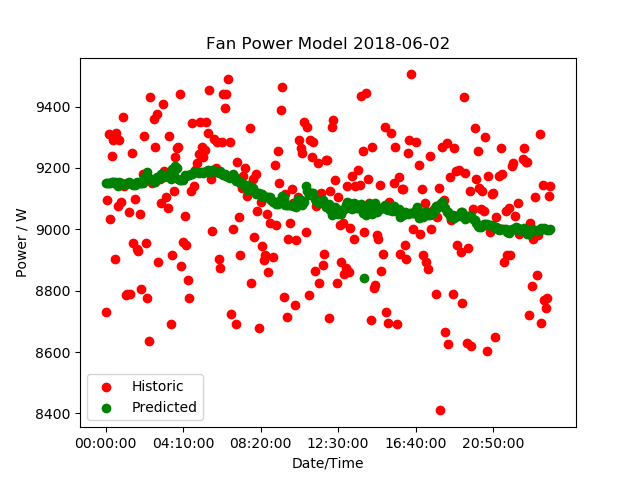

In [13]:
# Plot historic predictions
Xfiltered = XPower[select]
Yfiltered = YPower[select]

plt.scatter(np.arange(len(tseries)),
            ScalerYPower.inverse_transform(Yfiltered),
            c='r', label='Historic')
plt.scatter(np.arange(len(tseries)),
            ScalerYPower.inverse_transform(est.predict(Xfiltered)),
            c='g', label='Predicted')
plt.title('Fan Power Model ' + time.isoformat())
plt.ylabel('Power / W')
plt.xlabel('Date/Time')
plt.legend();
ticks, labels = plt.xticks()
ticks = np.asarray([t for t in ticks if 0 <= t < len(tseries)])
plt.xticks(ticks, tseries[ticks.astype(int)]);

<IPython.core.display.Javascript object>


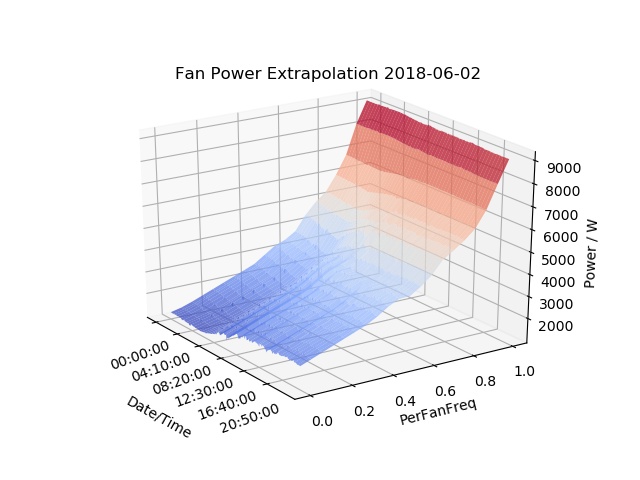

In [16]:
# Plot model predictions when varying a field
# var= 'TempCondIn'
var, var_idx = 'PerFanFreq', 0

vary_range = (std_power_var(var_idx, 0),
              std_power_var(var_idx, 1))
_, y, z = model_surface(POWER_MODELS['SingleMLP'], Xfiltered, (var_idx,),
                        (vary_range,), (20,))
ax = plot_surface(tseries,
                  norm_power_var(var_idx, y),
                  norm_power(z),
                  alpha=0.75, cmap=plt.get_cmap('coolwarm'))
ax.set_xlabel('Date/Time', labelpad=20)
ax.set_ylabel(var)
ax.set_zlabel('Power / W')
plt.title('Fan Power Extrapolation ' + time.isoformat());

<IPython.core.display.Javascript object>


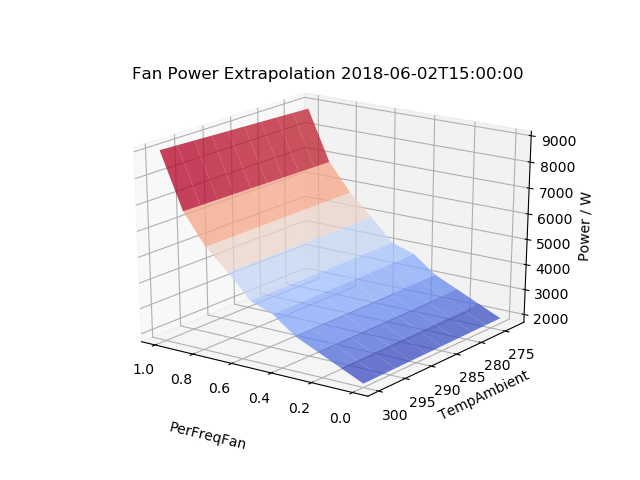

In [19]:
# Plot model predictions when varying 2 fields at a single time instant
dt = datetime.datetime(2018, 6, 2, 15, 0, 0)
select = df.index == dt
singleX, singleY = XPower[select], YPower[select]
var, var_idx = ('PerFreqFan', 'TempAmbient'), (0, 1)
vary_range = ((std_power_var(var_idx[0], 0), std_power_var(var_idx[0], 1)),
              (std_power_var(var_idx[1], 273), std_power_var(var_idx[1], 300)))

x, y, z = model_surface(POWER_MODELS['SingleMLP'], singleX, var_idx,
                        vary_range, (10, 10))
ax = plot_surface(norm_power_var(var_idx[0], x),
                  norm_power_var(var_idx[1], y),
                  norm_power(z),
                  alpha=0.75, cmap=plt.get_cmap('coolwarm'))
ax.set_xlabel(var[0], labelpad=20)
ax.set_ylabel(var[1])
ax.set_zlabel('Power / W')
plt.title('Fan Power Extrapolation ' + dt.isoformat());